# Avellaneda-Stoikov

In [2]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjCriterion
import torch

device = torch.device('mps')

print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


True
True


## Random strategy

In [3]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5

alpha = 0.001
seed = 42
np.random.seed(seed)
timestamps = np.linspace(0, terminal_time, n_steps + 1)

def get_cj_env(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories),
                      arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate,arrival_rate]), 
                                                           step_size=step_size, 
                                                          num_trajectories=num_trajectories),
                      fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories),
                      reward_function = CjCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

num_trajectories = 10
env = get_cj_env(num_trajectories)

random = RandomAgent(env,seed=seed)

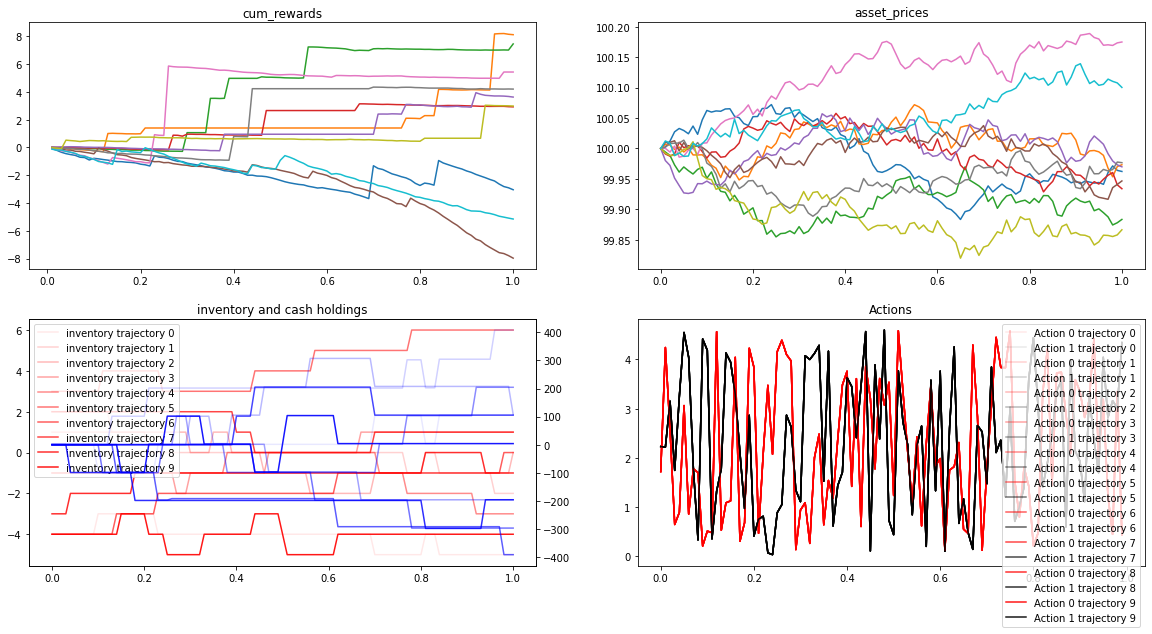

In [4]:
plot_trajectory(env, random, seed = seed)

## Fixed strategies

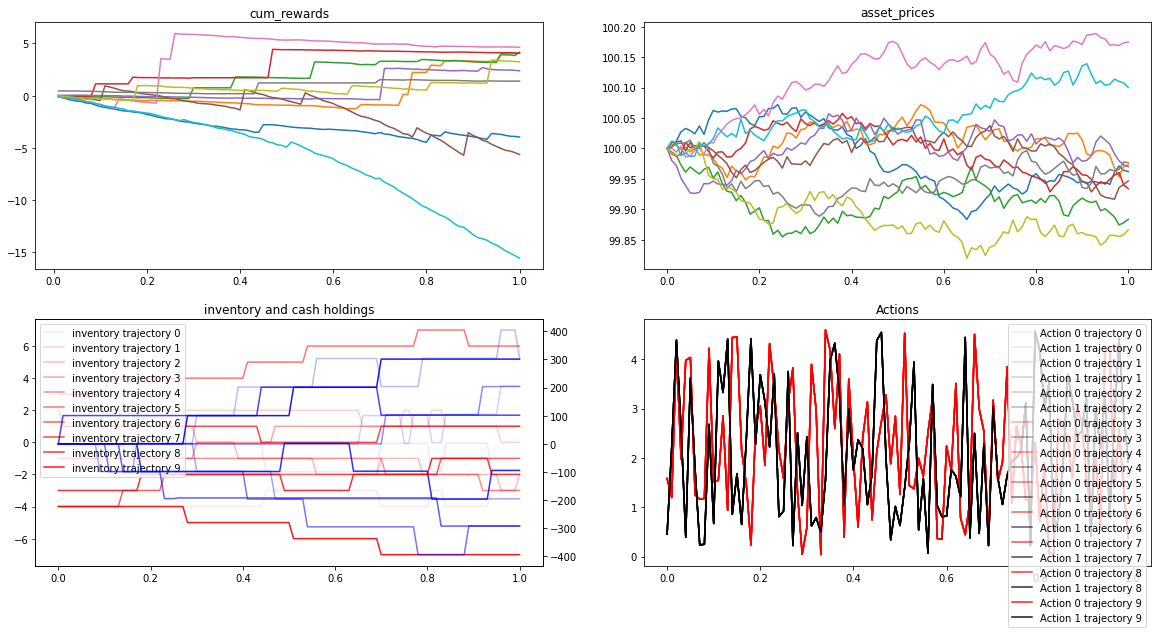

In [5]:
half_spreads = [0.25] #,0.5,1,2,4

num_trajectories = 10
env = get_cj_env(num_trajectories)

agent = FixedSpreadAgent(env, half_spread=0.25)
plot_trajectory(env, random, seed = seed)

In [6]:
performance_dict = {}

for hs in half_spreads:
    np.random.seed(42)
    agent = FixedSpreadAgent(env, half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], performance_dict[hs]["actions"], rewards = generate_trajectory(env, agent, seed = seed)
    # rewards = np.squeeze(rewards, axis=1)
    # performance_dict[hs]["cum_rewards"] = np.cumsum(rewards, axis=-1)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

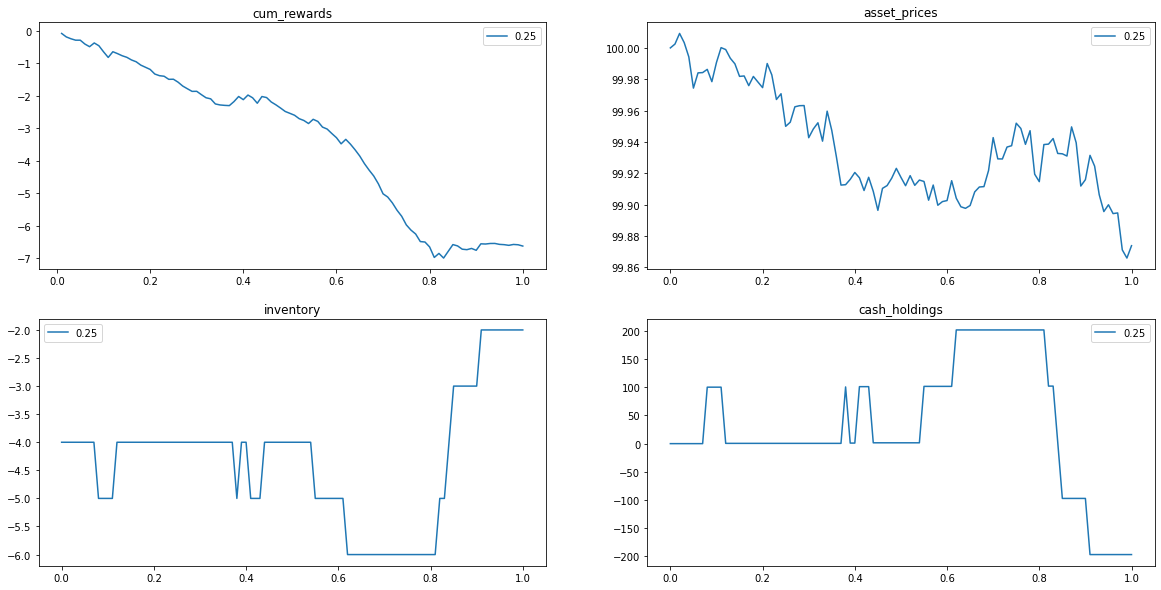

In [109]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps[1:],performance_dict[hs]["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict[hs]["observations"][:,3].reshape(-1), label = hs)
    ax3.plot(timestamps,performance_dict[hs]["observations"][:,1].reshape(-1), label = hs)
    ax4.plot(timestamps,performance_dict[hs]["observations"][:,0].reshape(-1), label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

## Avellaneda-Stoikov Optimal Strategy

In [17]:
def get_as_env(num_trajectories:int = 1):
    terminal_time = 1.0
    sigma = 2.0
    n_steps = 2000
    arrival_rate = 140
    fill_exponent = 1.5
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    return TradingEnvironment(terminal_time=terminal_time, 
                                 n_steps=n_steps, seed=seed, 
                                 num_trajectories=num_trajectories, 
                                 midprice_model=midprice_model,
                                 arrival_model=arrival_model, 
                                 fill_probability_model=fill_probability_model)

In [18]:
as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

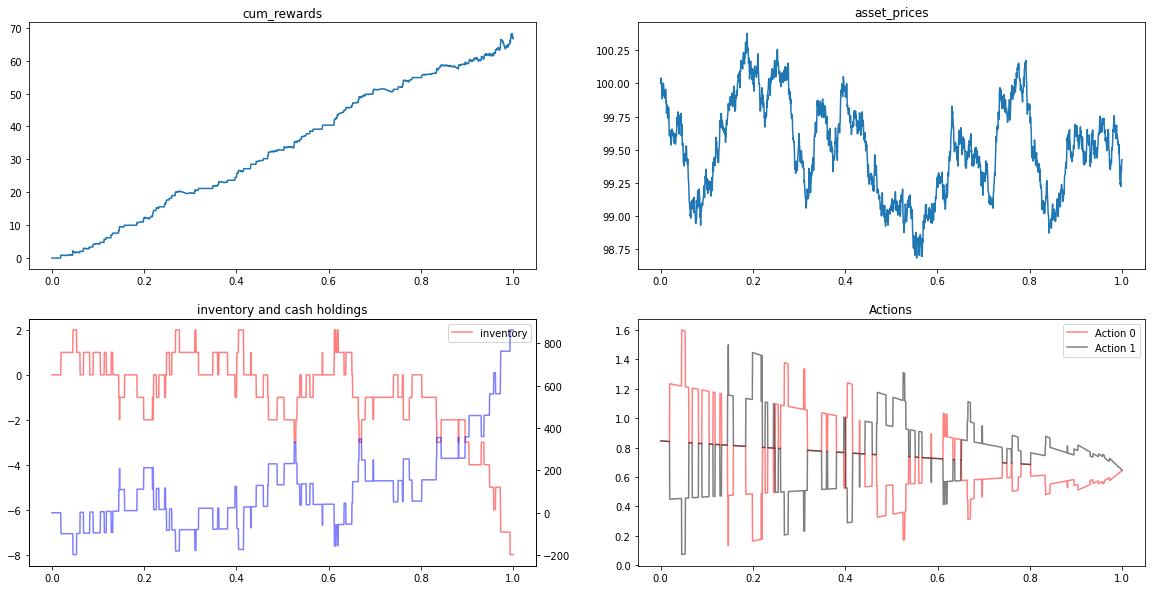

In [19]:
plot_trajectory(as_env, as_agent, seed = seed)

### Comparing the results to the Avellaneda Stoikov paper

In [20]:
num_trajectories = 100000
vec_env = get_as_env(num_trajectories)
vec_as = AvellanedaStoikovAgent(risk_aversion=0.1, env=vec_env)

In [21]:
observations, actions, rewards = generate_trajectory(vec_env, vec_as)

/Users/mwthomas/Documents/Stanford/Study/CME241-RLForFinance/Project/mbt_gym/notebooks/../mbt_gym/agents/BaselineAgents.py:66: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


KeyboardInterrupt: 

In [ ]:
results, fig, total_rewards = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as)

In [ ]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,1.49087,63.993267,7.218381,0.00764,3.377656


These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which _could_ be interpreted as taking liquidity but then the model should possibly be changed.

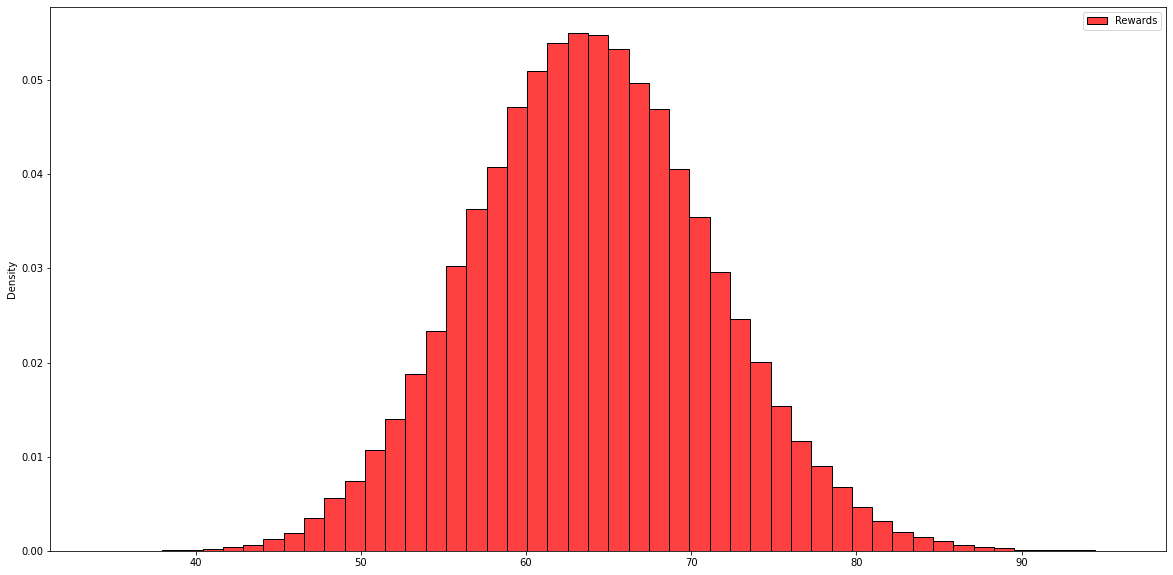

In [18]:
fig

### The effect of increasing risk aversion

In [19]:
risk_aversions = [0.01,0.1,0.5,1]

In [20]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    vec_as = AvellanedaStoikovAgent(risk_aversion=risk_aversion, env=vec_env)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as);   

C:\Users\Nirmay\Desktop\Academic\Savani, Jerome and Leandro\mbt_gym\mbt_gym\agents\BaselineAgents.py:61: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
C:\Users\Nirmay\Desktop\Academic\Savani, Jerome and Leandro\mbt_gym\mbt_gym\agents\BaselineAgents.py:61: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
C:\Users\Nirmay\Desktop\Academic\Savani, Jerome and Leandro\mbt_gym\mbt_gym\agents\BaselineAgents.py:61: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [21]:
colors = ["r", "g", "b", "c"]

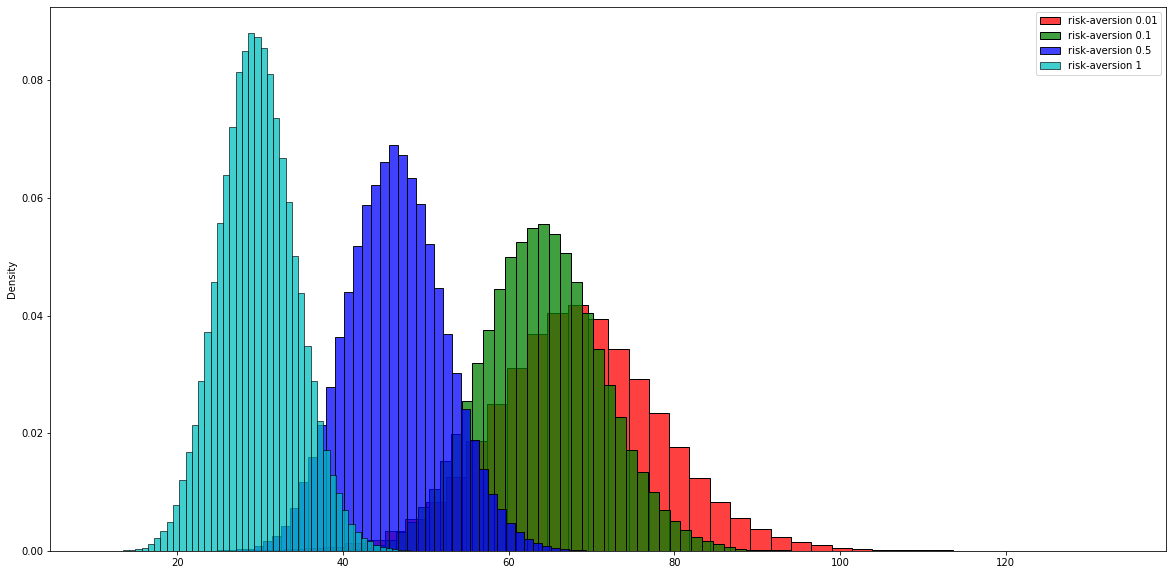

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

## The Cartea-Jaimungal agent

In [23]:
cj_agent = CarteaJaimungalAgent(phi=0.1, alpha=0.001,env=as_env, max_inventory=100)

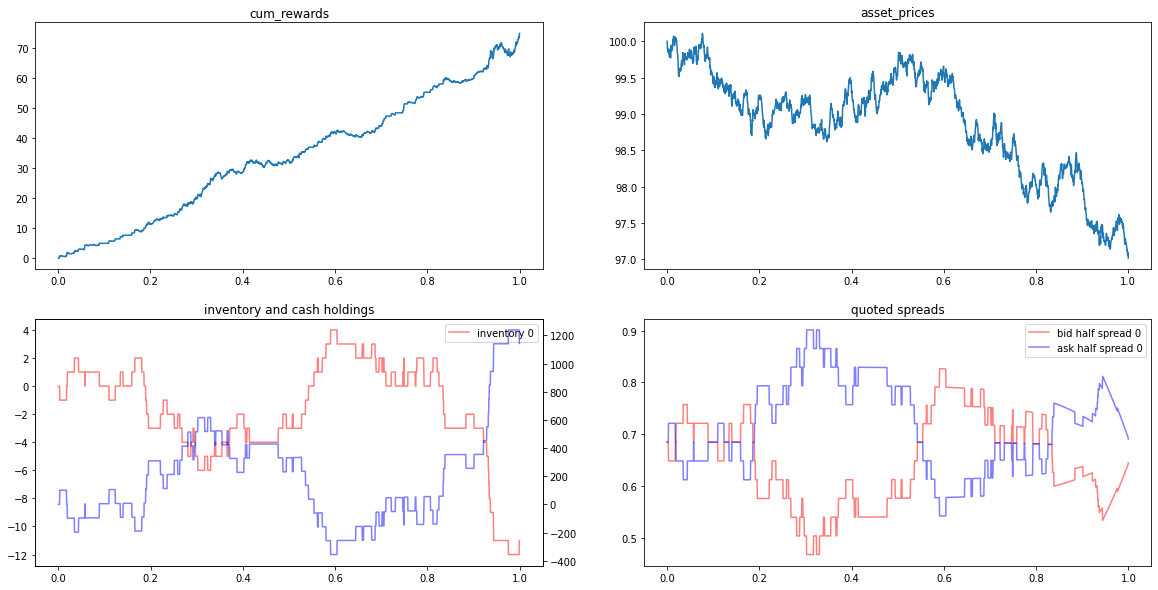

In [24]:
plot_trajectory(as_env, cj_agent, seed = seed)